In [1]:
import os

import pandas as pd

import numpy as np
from numpy import random

from random import sample

import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.feature import daisy, hog, ORB, local_binary_pattern, SIFT
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize, rotate, downscale_local_mean

from scipy import ndimage as ndi
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from skimage import exposure

# from tqdm import tqdm

import gc

from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from sklearn.preprocessing import Normalizer
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

from scipy.special import erfcinv

In [2]:
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

import math

In [3]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

In [4]:
# gabor filter

def createGaborfilterbank(m=39, n=39):
    garray = []
    fmax = 0.327 # maximum frequency
    gamma = np.sqrt(2)
    eta = np.sqrt(2)
    
    gamma = 0.5
    eta = 0.5
    
    u = 6 #number of frequencies
    v = 8 #number of orientation

    for i in range(0,u):

        fu = fmax/np.sqrt(2)**(i); # frequency
        alpha = fu/gamma;
        beta = fu/eta;

        for j in range(0,v):
            theta = j/v*np.pi; # orientation 

            x, y = np.meshgrid(np.arange(1,n+1,1), np.arange(1,m+1,1))

            xenvolope  =  (x-((m+1)/2))*np.cos(theta) + (y-((n+1)/2))*np.sin(theta);
            yenvolope  = -(x-((m+1)/2))*np.sin(theta) + (y-((n+1)/2))*np.cos(theta);
            
            gfilter = np.transpose(
                                (fu**2/(np.pi*gamma*eta))*np.exp(-((alpha**2)*(xenvolope**2) + 
                              (beta**2)*(yenvolope**2)))*np.exp(1j*2*np.pi*fu*xenvolope)
                                    );

            garray.append(gfilter);

    plt.figure(figsize=(15,10))

    for i in range(48):    
        ax = plt.subplot(6,8,i+1)
        # ax.set_title(label)
        plt.imshow(np.real(garray[i]),cmap='Greys_r')
        plt.axis("off")  
        
    return garray

def computeGaborfeatures(image, kernels):
    feats = []
    filteredimg = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, np.abs(kernel), mode='wrap')
            
        feats.append(filtered.mean())
        feats.append(filtered.std())
        
        filteredimg.append(filtered)
        
    return feats, filteredimg

In [5]:
def sg_solvefilterparams(k, p, m, n):

    gamma = solvegamma(k, p);
    eta = solveeta(n, p);

    return gamma, eta


def solvegamma(k,p):

    gamma = 1.0 / np.pi * np.sqrt(-np.log(p)) * (k + 1) / (k - 1);

    return gamma


def solvek(gamma,p):

    x = 1.0 / (gamma * np.pi)*np.sqrt(-np.log(p));
    k = (1 + x) / (1 - x);
    
    return k


def solvep(gamma,k):

    p = np.exp(- (gamma * np.pi * (k - 1) / (k + 1))**2);
    
    return p


def solveeta(n,p):

    ua = np.pi / n / 2; # ua based on approximation

    eta = 1.0 / np.pi * np.sqrt(-np.log(p)) / ua;
    
    return eta


In [6]:
def norminv(p,mu,sigma):
    
    x0 = np.multiply( -np.sqrt(2), (erfcinv(2 * p)) );
    x = np.multiply(sigma, x0) + mu;
    
    return x

In [7]:
def compute_fhigh(f0, a, b):
    
    d = f0;

    if b > a:

      foo = -( (a**2) * d )/(a**2 - b**2);

      if foo < a:
        fhigh2 = np.sqrt( (d + foo)**2 + (b/a * np.sqrt(a**2 - foo**2))**2 );
      else:
        fhigh2 = d + a;
    
    else:
        fhigh2 = d + a; 

    if fhigh2 > 0.5:
      fhigh2 = 0.5; 

    return fhigh2

In [8]:
def ellipsoid_envelope_point(a,b,c):

    x=(c*(a**2))/np.sqrt(b**2+c**2*a**2)
    y=b/a*np.sqrt(a**2-x**2);
    
    return np.array([x,y])

In [9]:
def accurate_envelope_f(f0,a,b,theta):

    if np.mod(theta, np.pi/2)!=0:

        # solve points with slopes -tan(pi/2-theta) and tan(theta)
        x1y1 = ellipsoid_envelope_point(a,b,-np.tan(np.pi/2-theta))
        x2y2 = ellipsoid_envelope_point(a,b,np.tan(theta))
        
        envelope = np.array([x1y1, -x1y1, x2y2, -x2y2])
    
        # shift by f0
        envelope = envelope + np.tile([f0, 0],[4,1])

        # rotate by theta
        envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))

        xmin = min(envelope[:,0]);
        xmax = max(envelope[:,0]);
        ymin = min(envelope[:,1]);
        ymax = max(envelope[:,1]);

        envelope=np.real([xmin, xmax, ymin, ymax])

    else: 

        envelope = np.array([[f0-a, 0], [f0+a, 0] , [f0, b], [f0, -b]])
        
        envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))
        
        xmin = min(envelope[:,0]);
        xmax = max(envelope[:,0]);
        ymin = min(envelope[:,1]);
        ymax = max(envelope[:,1]);
        
        envelope=np.real([xmin, xmax, ymin, ymax])

    return envelope
    

In [10]:
def computeAGaborFilter(f0, theta, gamma, eta, Nx, Ny):
    
    pf = np.sqrt(0.99) #energy to include in the filters
    alpha = f0 / gamma
    beta = f0 / eta
    
    # accurate rectangular envelope
    majenv = norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*gamma))
    minenv = norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*eta))
    
    fhigh = compute_fhigh(f0,majenv[1],minenv[1])
    
    envelope = accurate_envelope_f(f0,majenv[1],minenv[1],theta)
    
    envelope[:2] = envelope[:2] * Nx
    envelope[-2:] = envelope[-2:] * Ny
    
    envelope = np.array([np.floor(envelope[0]), np.ceil(envelope[1]), np.floor(envelope[2]), np.ceil(envelope[3])])
    
    nx = np.arange(envelope[0], envelope[1] + 1, 1, dtype=int)
    ny = np.arange(envelope[2], envelope[3] + 1, 1, dtype=int)
    
    u = nx/Nx; #frequencies that bank contains
    v = ny/Ny;
    
    U, V = np.meshgrid(u,v)
    
    Uenvelope =  (np.add(-U * np.sin(theta), V * np.cos(theta)))**2 / beta**2
    Venvelope =  (np.add(U * np.cos(theta), V * np.sin(theta) - f0))**2 / alpha**2
    
    gf = np.exp( -(np.pi**2) * np.add(Uenvelope,Venvelope) )
    
    return gf, envelope, fhigh
    

In [11]:
def transformtoSpatialGaborFiler(FrequencyGaborFilter, envelope, row, col):
    
    M1 = col
    M2 = row
    
    lx = envelope[1] - envelope[0];
    ly = envelope[3] - envelope[2];
    
    xx = np.int32(np.mod( np.arange(0,lx + 1) + envelope[0] + M1 , M1 ) + 1)-1;
    yy = np.int32(np.mod( np.arange(0,ly + 1) + envelope[2] + M2 , M2 ) + 1)-1;
    
    f2_ = np.zeros((M2,M1), dtype=np.float64)
    
    for y in range(0,len(yy)):
        for x in range(0,len(xx)):
            xf2 = xx[x] 
            yf2 = yy[y] 

            f2_[yf2,xf2] = FrequencyGaborFilter[y,x]
            
    f2 = np.fft.ifftshift( np.fft.ifft2(f2_) )
    
    return f2

In [13]:
def createSetOfGarborFilters(row=43, col=43):

    fmax = 0.327 # maximum frequency

    k = np.sqrt(2) #frequency ratio or factor for selecting filter frequencies
    
    p = 0.5 # crossing point between two consecutive filters, default 0.5
    # pf = np.sqrt(0.99) #energy to include in the filters
    
    u = 6 #number of frequencies
    v = 8 #number of orientation
    
    gamma, eta = sg_solvefilterparams(k, p, u, v) # smoothing parameters
    
    # gamma = np.sqrt(2)
    # eta = np.sqrt(2)
    
    arrFreqs = np.zeros(u) # store frequencies of filters 
    dMaxFHigh = 0 # store maximum frequency of all filter bank
    arrFHighs = np.zeros(u * v) # store maximum frequency of a filter bank
    arrOries = np.zeros(v) # store orientations of filters 
    arrFreqGaborFilters = [None] * u * v # store list of Gabor filters on frequency domain
    arrSpatGaborFilters = [None] * u * v # store list of Gabor filters on spatial domain
    arrEnvelopes = np.zeros((u * v, 4))
    
    for i in range(0,u):

        fu = fmax/k**i # frequency of the filter
        
        arrFreqs[i] = fu
        
        for j in range(0,v):
            theta = j/v*np.pi; # orientation of the filter 
            
            FreqGaborFilter, envelope, fhigh = computeAGaborFilter(fu, theta, gamma, eta, row, col) 
            
            SpatGaborFilters = transformtoSpatialGaborFiler(FreqGaborFilter, envelope, row, col) # for visualization
                  
            if fhigh > dMaxFHigh:
                dMaxFHigh = fhigh
            
            # arrFreqs[i * v + j] = fu
            arrFHighs[i * v + j] = fhigh
            arrEnvelopes[i * v + j] = envelope
            # arrOries[i * v + j] = theta
            arrOries[j] = theta
            arrFreqGaborFilters[i * v + j] = FreqGaborFilter
            arrSpatGaborFilters[i * v + j] = SpatGaborFilters # for visualization
            
            # display(envelope)
            # print(i,j, i * v + j)
        
    return arrFreqs, dMaxFHigh, arrFHighs, arrOries, arrEnvelopes, arrFreqGaborFilters, arrSpatGaborFilters

In [14]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv')
dfFoldTraining_1.index[dfFoldTraining_1['short_filenames'] == "0064-cop_calanoida_ptt.png"].tolist()

[11838]

(-0.5, 133.5, 133.5, -0.5)

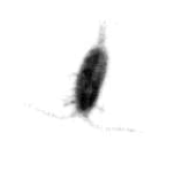

In [15]:
img = io.imread(dfFoldTraining_1["filenames"][11838])

plt.figure(figsize=(5,2))

plt.imshow(img,cmap='Greys_r')

plt.axis("off") 

In [16]:
img.shape

(134, 134)

In [17]:
arrFreqs, dMaxFHigh, arrFHighs, arrOries, arrEnvelopes, arrFreqGaborFilters, arrSpatGaborFilters = createSetOfGarborFilters(img.shape[0], img.shape[1])

<Figure size 1500x1000 with 0 Axes>

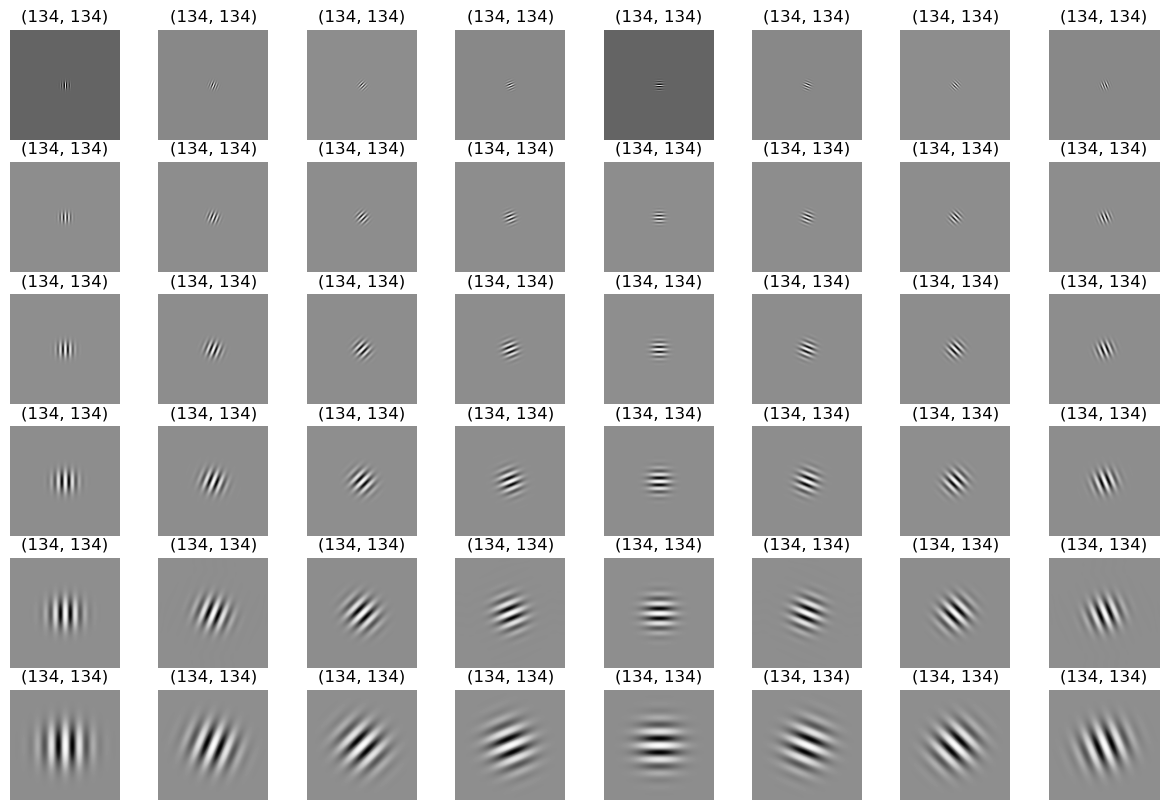

<Figure size 1500x1000 with 0 Axes>

In [18]:
plt.figure(figsize=(15,10))
for i in range(48):    
    ax = plt.subplot(6,8,i+1)
    # ax.set_title(label)
    plt.imshow(np.real(arrSpatGaborFilters[i]),cmap='Greys_r')
    label = str(np.real(arrSpatGaborFilters[i]).shape)
    ax.set_title(label)
    plt.axis("off") 
    
plt.figure(figsize=(15,10))

In [20]:
arrMN.size

2

In [22]:
arrMN = np.array([img.shape[1], img.shape[0]])
arrMZooms = np.zeros(len(arrFreqs))
dMMaxZoom = 0
arrMRespSize = np.zeros((len(arrFreqs), arrMN.size), dtype=object)
arrMActualZoom = np.zeros((len(arrFreqs), arrMN.size), dtype=object)

for idxFreq in range(len(arrFreqs)):
    dZoom = 0.5 / arrFHighs[idxFreq * len(arrOries)]
    
    if dMMaxZoom > 0 and dZoom > dMMaxZoom:
        dZoom = dMMaxZoom
    
    if dZoom < 1:
        printf('Zoom factor smaller than 1, wtf?\n');
        dZoom = 1;
        
    arrMZooms[idxFreq] = dZoom
    
    # print(dZoom, arrN)
    
    # the responsesize is always wanted to be divisible by two
    arrMRespSize[idxFreq] = np.int32(np.round(arrMN / dZoom / 2) * 2); 

    # actual zoom factor
    arrMActualZoom[idxFreq] = arrMN / arrMRespSize[idxFreq];
    
print(arrMZooms)

print(arrMRespSize)
print(arrMActualZoom)


# perform the filtering
fimg = np.fft.fft2(np.fft.ifftshift(img_as_float(img)))


# arrMFreqs = np.zeros(len(arrFreqs))
# arrCustomPoints = []

# for idxFreq in range(len(arrFreqs)):
#     f0 = arrFreqs[idxFreq]
    
#     arrMFreqs[idxFreq] = f0
    
#     # zero memory for filter responses, each frequency is of different size now 
#     if not arrCustomPoints
#         #m.freq{find}.resp=zeros(length(bank.freq{find}.orient),m.respSize(find,2),m.respSize(find,1))
        

[1.08526161 1.53479169 2.17052322 3.06958338 4.34104645 6.13916676]
[[124 124]
 [88 88]
 [62 62]
 [44 44]
 [30 30]
 [22 22]]
[[1.0806451612903225 1.0806451612903225]
 [1.5227272727272727 1.5227272727272727]
 [2.161290322580645 2.161290322580645]
 [3.0454545454545454 3.0454545454545454]
 [4.466666666666667 4.466666666666667]
 [6.090909090909091 6.090909090909091]]


In [57]:
arrEnvelopes

array([[ 25.,  62., -21.,  21.],
       [ 22.,  59.,  -4.,  37.],
       [ 11.,  51.,  11.,  51.],
       [ -4.,  37.,  22.,  59.],
       [-21.,  21.,  25.,  62.],
       [-37.,   4.,  22.,  59.],
       [-51., -11.,  11.,  51.],
       [-59., -22.,  -4.,  37.],
       [ 18.,  44., -15.,  15.],
       [ 15.,  42.,  -3.,  27.],
       [  8.,  36.,   8.,  36.],
       [ -3.,  27.,  15.,  42.],
       [-15.,  15.,  18.,  44.],
       [-27.,   3.,  15.,  42.],
       [-36.,  -8.,   8.,  36.],
       [-42., -15.,  -3.,  27.],
       [ 12.,  31., -11.,  11.],
       [ 11.,  30.,  -2.,  19.],
       [  5.,  26.,   5.,  26.],
       [ -2.,  19.,  11.,  30.],
       [-11.,  11.,  12.,  31.],
       [-19.,   2.,  11.,  30.],
       [-26.,  -5.,   5.,  26.],
       [-30., -11.,  -2.,  19.],
       [  9.,  22.,  -8.,   8.],
       [  7.,  21.,  -2.,  14.],
       [  4.,  18.,   4.,  18.],
       [ -2.,  14.,   7.,  21.],
       [ -8.,   8.,   9.,  22.],
       [-14.,   2.,   7.,  21.],
       [-1

In [234]:
np.squeeze(arrMRespSize[0]).tolist()

[124, 124]

In [227]:
arrMRespSize[0].flatten().tolist()

[124, 124]

In [243]:
a = np.zeros((8, np.squeeze(arrMRespSize[0])[0], np.squeeze(arrMRespSize[0])[1]))


In [75]:
fimg.shape

(134, 134)

In [94]:
xx

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62])

In [95]:
yy

array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21])

In [96]:
xx_z

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62])

In [97]:
yy_z

array([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21])

In [68]:
np.take(fimg, yy_z).shape

(43,)

In [84]:
Ni, Nk = fimg.shape[:0], fimg.shape[1:]

display(Ni, Nk)

()

(134,)

In [91]:
fimg.shape

(134, 134)

In [99]:
fimgtest = np.zeros((len(yy),len(xx)), dtype=np.complex_)

for y in range(0,len(yy)):
    for x in range(0,len(xx)):
        xf2 = xx[x] 
        yf2 = yy[y] 

        fimgtest[y,x] = fimg[yf2,xf2]

In [104]:
fimgtest.shape

(43, 38)

In [103]:
arrFreqGaborFilters[idxFreq * len(arrFreqs) + idxOrien].shape

(43, 38)

In [107]:
np.multiply(arrFreqGaborFilters[idxFreq * len(arrFreqs) + idxOrien], fimgtest)

array([[ 1.65653483e-04-4.56568570e-06j,  3.05952945e-04+1.19394296e-04j,
         3.45817610e-04+1.64991642e-04j, ...,
         1.33273185e-04-2.68203931e-04j, -7.35869771e-05+4.48434503e-05j,
        -1.26775486e-04-1.00746745e-04j],
       [-3.08323860e-04-1.46618463e-04j, -9.99752371e-05+1.39161777e-04j,
         3.46378511e-04+3.03031699e-04j, ...,
         3.90303250e-05+2.10711032e-04j,  2.35612358e-04+3.21898808e-04j,
        -7.43716055e-05+1.90507324e-05j],
       [-3.09800309e-05+2.31431761e-04j, -8.25043236e-05+1.53024165e-04j,
         1.20215603e-04+7.18620764e-04j, ...,
         5.23442421e-04-6.56447372e-04j,  3.54522989e-04-5.36167280e-04j,
        -2.91754365e-04-1.21707462e-04j],
       ...,
       [ 9.61331569e-04-8.84140993e-04j,  2.24000175e-03-1.05632538e-03j,
         3.30643435e-04-3.60375715e-04j, ...,
         6.56761304e-04-4.72194856e-04j, -1.50087026e-05-2.59097561e-04j,
        -4.11894770e-05+1.01697066e-05j],
       [ 1.81202676e-04+1.00915460e-04j,  1.

In [112]:
f2_[123,26]

(-0.022573805938710546+0.1113078484395591j)

In [113]:
f2 = np.fft.ifftshift( np.fft.ifft2(f2_) )

In [116]:
display(arrMActualZoom[idxFreq])
display(arrMActualZoom[idxFreq].prod())


array([1.0806451612903225, 1.0806451612903225], dtype=object)

1.1677939646201871

In [117]:
np.divide(f2, arrMActualZoom[idxFreq].prod())

array([[-1.58547778e-08+1.31532876e-08j, -1.31061562e-08-2.48587902e-09j,
        -9.25278744e-09-1.83171743e-08j, ...,
         5.98904339e-09-1.91501199e-08j,  1.66324334e-08-7.10581257e-09j,
         1.49302043e-08+1.94485026e-08j],
       [-5.95853596e-08+3.39320569e-08j, -4.69807976e-08-2.28118787e-08j,
         4.17339176e-09-7.31914833e-08j, ...,
         3.13360229e-08-5.53476936e-08j,  5.52083248e-08-1.17925924e-08j,
         3.54053019e-08+7.03330268e-08j],
       [-1.54910278e-07+7.55187044e-08j, -1.07451891e-07-6.23810623e-08j,
         1.56957697e-08-1.81437669e-07j, ...,
         8.94670205e-08-1.32236240e-07j,  1.30072638e-07-1.97518199e-08j,
         8.21269778e-08+1.74759223e-07j],
       ...,
       [-4.56760280e-09-2.00269520e-09j, -3.68929315e-09-7.47125060e-09j,
         1.34925805e-08-6.39269789e-09j, ...,
         5.14016909e-09-9.16448008e-11j,  3.81613812e-09+5.34103415e-09j,
        -5.52885389e-09+4.84920973e-09j],
       [-1.15183654e-09-3.61821013e-09j,  3.

In [118]:
arrMFreqs = np.zeros(len(arrFreqs))
arrCustomPoints = []
arrMResps = [None]*len(arrFreqs)
arrMFreqZooms = np.zeros(len(arrFreqs))
for idxFreq in range(0,1):
    print(idxFreq)
    f0 = arrFreqs[idxFreq]
    
    arrMFreqs[idxFreq] = f0
    
    # zero memory for filter responses, each frequency is of different size now 
    if not arrCustomPoints:
        arrMResps[idxFreq] = np.zeros((len(arrOries), np.squeeze(arrMRespSize[0])[1], np.squeeze(arrMRespSize[0])[0]))
        
        # loop through orientations
        for idxOrien in range(0,1):
            print(idxOrien)
            a = arrEnvelopes[idxFreq * len(arrFreqs) + idxOrien]
            
            fhigh = arrFHighs[idxFreq * len(arrFreqs) + idxOrien]
            
            arrMFreqZooms[idxFreq] = arrMZooms[idxFreq]
            
            f2_ = np.zeros((arrMRespSize[idxFreq, 1] , arrMRespSize[idxFreq, 0]), dtype=np.complex_)
            
            lx = a[1]-a[0];
            ly = a[3]-a[2];
            
            # coordinates for the filter area in filtered fullsize image
            xx = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMN[0] , arrMN[0] ) + 1) - 1;
            yy = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMN[1] , arrMN[1] ) + 1) - 1;
            
            # coordinates for the filter area in downscaled response image
            xx_z = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMRespSize[idxFreq, 0], arrMRespSize[idxFreq, 0]));
            yy_z = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMRespSize[idxFreq, 1], arrMRespSize[idxFreq, 1]));
            
            fs = np.zeros((len(yy),len(xx)), dtype=np.complex_)
            for y in range(0,len(yy)):
                for x in range(0,len(xx)):
                    xf2 = xx[x] 
                    yf2 = yy[y] 
                    fs[y,x] = fimg[yf2,xf2]
                    
            multifsgb = np.multiply(arrFreqGaborFilters[idxFreq * len(arrFreqs) + idxOrien], fs)
            
            for y in range(0,len(yy_z)):
                for x in range(0,len(xx_z)):
                    xf2 = xx_z[x] 
                    yf2 = yy_z[y] 
                    f2_[yf2,xf2] = multifsgb[y,x]
            
            arrMResps[idxFreq] = np.divide(np.fft.ifftshift( np.fft.ifft2(f2_) ), arrMActualZoom[idxFreq].prod())

0
0


In [121]:
arrMResps[1].shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [205]:
arrMFreqs = np.zeros(len(arrFreqs))
arrCustomPoints = []
# arrMResps = np.zeros(len(arrFreqs))
arrMFreqZooms = np.zeros(len(arrFreqs))
for idxFreq in range(len(arrFreqs)):
    f0 = arrFreqs[idxFreq]
    
    arrMFreqs[idxFreq] = f0
    
    # zero memory for filter responses, each frequency is of different size now 
    if not arrCustomPoints:
        arrMResps[idxFreq] = np.zeros((len(arrOries), np.squeeze(arrMRespSize[0])[1], np.squeeze(arrMRespSize[0])[0]))
        
        # loop through orientations
        for idxOrien = in range(len(arrOries)):
            a = arrEnvelopes[idxFreq * len(arrFreqs) + idxOrien]
            
            fhigh = arrFHighs[idxFreq * len(arrFreqs) + idxOrien]
            
            arrMFreqZooms[idxFreq] = arrMZooms[idxFreq]
            
            f2_ = np.zeros(arrMRespSize[idxFreq, 1] , arrMRespSize[idxFreq, 0], dtype=np.float64);
            
            lx = a[1]-a[0];
            ly = a[3]-a[2];
            
            # coordinates for the filter area in filtered fullsize image
            xx=mod( (0:lx) + a(1) + N(1) , N(1) ) + 1;
            yy=mod( (0:ly) + a(3) + N(2) , N(2) ) + 1;
            
            xx = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMN[0] , arrMN[0] ) + 1)-1;
            yy = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMN[1] , arrMN[1] ) + 1)-1;
            
            # coordinates for the filter area in downscaled response image
            xx_z = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMRespSize[find,0], arrMRespSize[find,0])) + 1;
            yy_z = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMRespSize[find,1], arrMRespSize[find,1])) + 1;
            
            # filter the image
            # f2_(yy_z,xx_z) = bank.freq{find}.orient{oind}.filter .* fs(yy,xx);
            np.matmul(arrFreqGaborFilters[idxFreq * len(arrFreqs) + idxOrien]
            for y in range(0,len(yy_z)):
                for x in range(0,len(xx_z)):
                    xf2 = xx_z[x] 
                    yf2 = yy_z[y] 

                    f2_[yf2,xf2] = FrequencyGaborFilter[y,x]
            
#     f2_ = np.zeros((M2,M1), dtype=np.float64)
    
#     for y in range(0,len(yy)):
#         for x in range(0,len(xx)):
#             xf2 = xx[x] 
#             yf2 = yy[y] 

#             f2_[yf2,xf2] = FrequencyGaborFilter[y,x]
            
    # f2 = np.fft.ifftshift( np.fft.ifft2(f2_) )

In [192]:
# perform the filtering

fimg = np.fft.fft2(np.fft.ifftshift(img_as_float(img)));

In [193]:
fimg.shape

(134, 134)

In [199]:
fimg[0:10,0]


array([ 1.68877804e+04  +0.j        , -7.25112051e+02-164.21490949j,
       -1.88263114e+02 -65.59557984j,  4.91296329e+01 +52.42975997j,
        6.48958339e+01 +69.53074402j,  2.25280403e+01  +3.34704139j,
        1.50969625e+01 -54.83903663j,  1.05861517e+01 -22.49983091j,
        4.05698938e+00 +18.81036894j,  1.97934598e+00  +9.24255004j])

In [191]:
imgttt = img_as_float(img)

In [190]:
imgttt

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])